In [1]:
from typing import NamedTuple

import os

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style("whitegrid")

from pygmo import hypervolume

tfd = tfp.distributions

In [2]:
def load_experiments(benchmark, method, num_experiments, num_evaluations, num_targets):
    experiment_paths = [os.path.join(experiment_folder, benchmark, method, f"experiment_{index}")
                        for index in range(num_experiments)]

    experiment_results = {}
    num_skipped = 0

    for experiment_path in experiment_paths:
        evaluation_path = os.path.join(experiment_path, f"evaluation_{num_evaluations - 1}", "ys.npy")

        if not os.path.exists(evaluation_path):
            num_skipped = num_skipped + 1
            #print(evaluation_path)
            continue

        # Note that we only retain the target dimensions
        experiment_results[os.path.basename(experiment_path)] = np.load(evaluation_path)[:, -num_targets:]

    print(f"Skipped {num_skipped}")

    exp_ys = np.concatenate([ys for _, ys in experiment_results.items()], axis=0)
    
    return experiment_results, exp_ys

In [3]:
def calculate_hypervolumes(exp_results, ys_min, ys_max, num_targets):
    hypervolumes = {}

    for label, data in exp_results.items():

        norm_data = (data - ys_min) / (ys_max - ys_min)

        hvs = []

        for i in range(1, norm_data.shape[0]):
            hv = hypervolume(points=norm_data[:i, :]).compute(np.ones(num_targets))
            hvs.append(hv)

        hypervolumes[label] = hvs
        
    return hypervolumes

In [4]:
def calculate_statistics(hypervolumes, num_resamples, num_warmup=10):

    hypervolume_mat = tf.stack([hvols for _, hvols in hypervolumes.items()], axis=0)
    num_empirical_samples = hypervolume_mat.shape[0]

    emp_dist = tfd.Empirical(samples=hypervolume_mat, event_ndims=1)
    emp_median = tfp.stats.percentile(hypervolume_mat, 50, axis=0, keep_dims=True)

    resamples = emp_dist.sample([num_empirical_samples, num_resamples])
    resample_medians = tfp.stats.percentile(resamples, 50, axis=0)

    bootstrap_deviations = resample_medians - emp_median

    percent_99_conf_intervals = tfp.stats.percentile(bootstrap_deviations, [0.5, 99.5], axis=0)
    percent_90_conf_intervals = tfp.stats.percentile(bootstrap_deviations, [5, 95], axis=0)
    percent_80_conf_intervals = tfp.stats.percentile(bootstrap_deviations, [10, 90], axis=0)
    
    return {
        "median": emp_median[0],
        "80_conf": percent_80_conf_intervals,
        "90_conf": percent_90_conf_intervals,
        "99_conf": percent_99_conf_intervals,
    }

In [5]:
class Setting(NamedTuple):
    name: str
    color: str

method_settings = {
    "sgs": Setting("SGS", "black"),
    "ff-gp": Setting("FF-GP", "red"),
    "gpar-targets": Setting("GPAR (targets only)", "blue"),
    "gpar-full": Setting("GPAR (with aux. outputs)", "green"),
    "bnn": Setting("BNN (50 samples)", "orange"),
}

In [12]:
def plot_experiments(benchmark,
                     methods,
                     num_experiments,
                     num_evaluations,
                     num_targets,
                     num_resamples,
                     ylims=None):
    all_ys = []
    all_experiment_results = {}

    for method in methods:
        print(f"Loading {method}")
        method_results, method_ys = load_experiments(benchmark, 
                                                     method, 
                                                     num_experiments, 
                                                     num_evaluations, 
                                                     num_targets)

        all_experiment_results[method] = method_results
        all_ys.append(method_ys)

    all_ys = np.concatenate(all_ys, axis=0)

    ys_max = np.max(all_ys, axis=0)
    ys_min = np.min(all_ys, axis=0)

    all_experiment_hypervolumes = {method: calculate_hypervolumes(method_results, ys_min, ys_max, num_targets)
                               for method, method_results in all_experiment_results.items()}

    all_experiment_statistics = {method: calculate_statistics(hypervolumes, num_resamples)
                               for method, hypervolumes in all_experiment_hypervolumes.items()}
    
    # Plot
    
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.set_title(f"Method comparison on {benchmark} \n Medians with 99% CIs", fontsize=20)

    eval_numbers = np.arange(1, 10 + num_evaluations)

    for method, statistics in all_experiment_statistics.items():

        ax.plot(eval_numbers, 
                statistics["median"], 
                label=f"{method_settings[method].name}", 
                c=method_settings[method].color, 
                zorder=4)


        ax.fill_between(eval_numbers,
                        statistics["median"] + statistics["99_conf"][0, :],
                        statistics["median"] + statistics["99_conf"][1, :],
                        alpha=0.1, 
                        color=method_settings[method].color,)
                        #label="99% confidence bootstrap interval")

        ax.set_ylabel("Hypervolume", fontsize=18)
        ax.set_xlabel("Iteration", fontsize=18)

        ax.set_xlim([10, 79])
        
        if ylims is not None:
            ax.set_ylim(ylims)

        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.legend(fontsize=18, loc='lower right')

    fig.tight_layout()

    fig.savefig(f"./{benchmark}_comparisons.png")

    plt.show()

In [13]:
experiment_folder = "/rds/user/gf332/hpc-work/BayesOpt/experiments"
benchmark = "fft_transpose"
methods = [
    "sgs",
    "ff-gp",
    "gpar-targets",
    "gpar-full",
    "bnn",
]
num_experiments = 50
num_evaluations = 70
num_targets = 3
num_resamples = 10000

Loading sgs
Skipped 0
Loading ff-gp
Skipped 0
Loading gpar-targets
Skipped 0
Loading gpar-full
Skipped 0
Loading bnn
Skipped 0


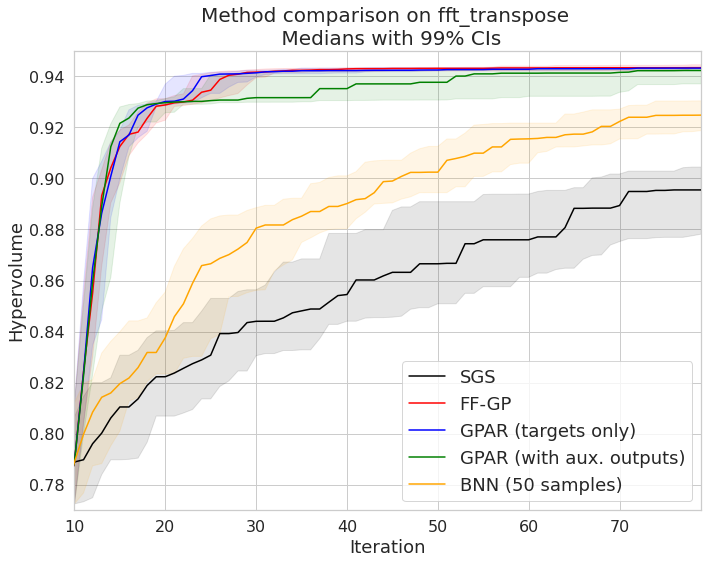

In [14]:
plot_experiments("fft_transpose",
                 methods,
                 num_experiments,
                 num_evaluations,
                 num_targets,
                 num_resamples,
                 ylims=[.77, .95])

Loading sgs
Skipped 0
Loading ff-gp
Skipped 0
Loading gpar-targets
Skipped 0
Loading gpar-full
Skipped 0
Loading bnn
Skipped 0


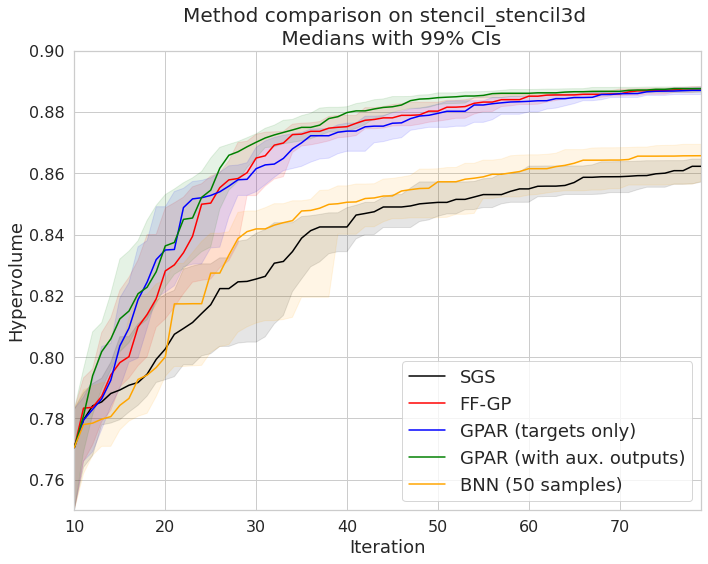

In [15]:
plot_experiments(benchmark="stencil_stencil3d",
                 methods=methods,
                 num_experiments=50,
                 num_evaluations=70,
                 num_targets=3,
                 num_resamples=10000,
                 ylims=[.75, .9])

Loading sgs
Skipped 0
Loading ff-gp
Skipped 0
Loading gpar-targets
Skipped 0
Loading gpar-full
Skipped 0
Loading bnn
Skipped 0


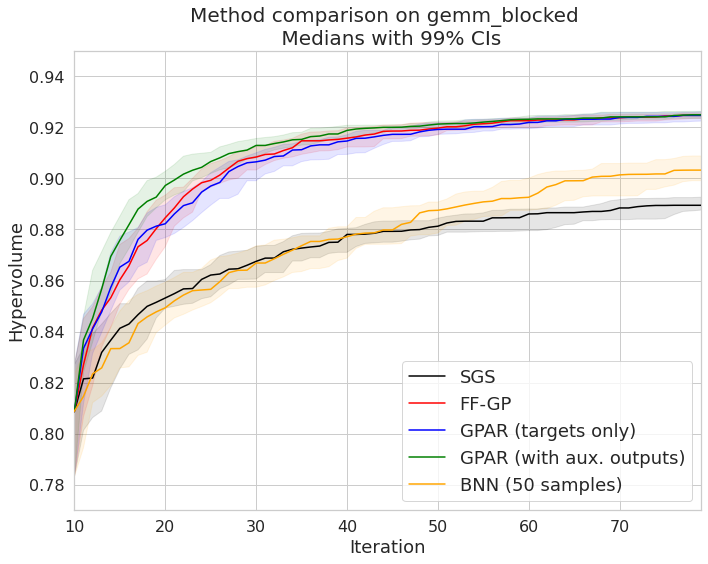

In [16]:
plot_experiments(benchmark="gemm_blocked",
                 methods=methods,
                 num_experiments=50,
                 num_evaluations=70,
                 num_targets=3,
                 num_resamples=10000,
                 ylims=[.77, .95])

In [11]:
for method, exps in all_experiment_hypervolumes.items():
    print(f"{method}: {exps['experiment_22'][10]}")

NameError: name 'all_experiment_hypervolumes' is not defined